<font size="+3"><strong>Predicting Price with Neighborhood</strong></font>

In [ ]:
!pip install category_encoders

In [ ]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# **Prepare Data**

## **Import**

In [ ]:
def wrangle(filepath):
      # Import_csv
      df = pd.read_csv(filepath)

      # Subset data: Apartments in "Capital Federal", less than 400,000
      mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
      mask_apt = df["property_type"] == "apartment"
      mask_price = df["price_aprox_usd"] < 400_000
      df = df[mask_ba & mask_apt & mask_price]

      # Split "lat-lon" column
      df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
      df.drop(columns="lat-lon", inplace=True)


      # Drop features with high null counts
      df.drop(columns = ["floor","expenses"], inplace= True)

      # Drop low and high cardinality categorical variables
      df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)

      # Drop Leakey columns
      df.drop(columns= [
          "price",
          "price_aprox_local_currency",
          "price_per_m2",
          "price_usd_per_m2"
           ],
      inplace= True)

      # Drop columns with multicollinearity
      df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

      # Subset data: Remove outliers for "surface_covered_in_m2"
      low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
      mask_area = df["surface_covered_in_m2"].between(low, high)
      df = df[mask_area]

      # Get place name
      df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3]
      df.drop(columns="place_with_parent_names", inplace=True)

      return df

In [ ]:
# Create a list that contains the filenames for all real estate CSV files
files = glob("buenos-aires-real-estate-*.csv")

# Use the wrangle function in a for loop to create a list named frames
frames = []
for file in files:
   df= wrangle(file)
   frames.append(df)

# Use `pd.concat` to concatenate the items in frames into a single DataFrame `df`
df = pd.concat(frames, ignore_index= True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,112000.0,60.0,-34.564676,-58.455720,Belgrano
1,76500.0,36.0,-34.618830,-58.437779,Caballito
2,90000.0,100.0,-34.577168,-58.538654,Belgrano
3,159900.0,77.0,-34.571526,-58.455637,Colegiales
4,123875.0,50.0,-34.578688,-58.457358,Colegiales


## **Explore**

In [ ]:
# Group the data by destination state and reporting airline. Compute total number of flights in each combination
bar_data = df.groupby(['neighborhood'])['price_aprox_usd'].mean().reset_index()
# Display the data
bar_data.sort_values(by='price_aprox_usd').tail()

,neighborhood,price_aprox_usd
7,Belgrano,165563.917301
6,Barrio Norte,174402.127474
36,Recoleta,191763.652603
20,Las Cañitas,193203.866667
35,Puerto Madero,249409.478261


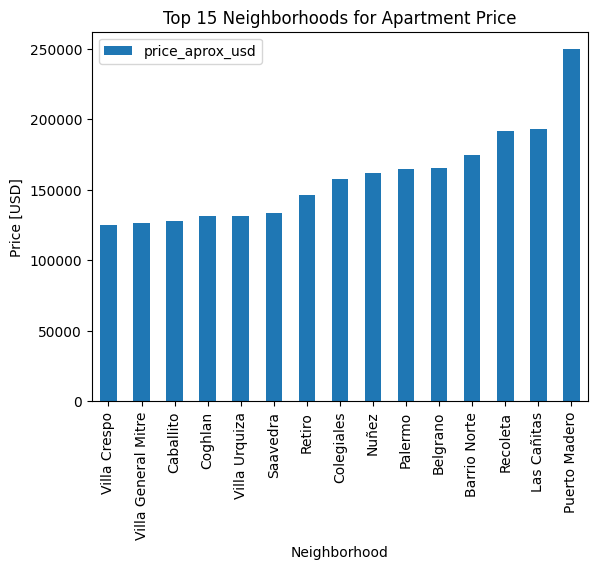

In [ ]:
# Create bar chart
bar_data.sort_values(by='price_aprox_usd').tail(15).plot(kind= "bar",x="neighborhood", y="price_aprox_usd")
plt.xlabel("Neighborhood")
plt.ylabel("Price [USD]")
plt.title("Top 15 Neighborhoods for Apartment Price");

## **Split**

In [ ]:
# Create feature matrix and target vector
features = ["neighborhood"]
target = "price_aprox_usd"
y = df[target]
X = df[features]
print(X.shape)
print(y.shape)

(6582, 1)
(6582,)


In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5265, 1)
y_train shape: (5265,)
X_test shape: (1317, 1)
y_test shape: (1317,)


# Build Model

## Baseline

In [ ]:
# Calculate the baseline mean absolute error
y_mean= y_train.mean()
y_pred_baseline =[y_mean] * len(y_train)
print("Mean apartment price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apartment price: 132015.15
Baseline MAE: 44393.95213998732


## Iterate

In [ ]:
# Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor
model = make_pipeline(
        OneHotEncoder(use_cat_names= True),
        LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

## Evaluate

In [ ]:
# Calculate the training mean absolute error
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 39198.66121557455


In [ ]:
r2_square_train = metrics.r2_score(y_train, y_pred_training)
r2_square_train

0.22133943506318976

In [ ]:
# Calculate the testing mean absolute error
y_pred_test = pd.Series(model.predict(X_test))
print(y_pred_test.head())
mae_testing = mean_absolute_error(y_test, y_pred_test)
print("Testing MAE:", round(mae_testing, 2))

0    128000.0
1     98176.0
2    111360.0
3    129792.0
4    164736.0
dtype: float64
Testing MAE: 812368101112651.6


In [ ]:
r2_square_test = metrics.r2_score(y_test, y_pred_test)
r2_square_test

-2.3411187121709754e+23

# Results

In [ ]:
# Extract the intercept and coefficients for our model
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])

coefficients len: 56
[-1.06988879e+18 -1.06988879e+18 -1.06988879e+18 -1.06988879e+18
 -1.06988879e+18]


In [ ]:
# Extract the feature names
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])

features len: 56
['neighborhood_Palermo' 'neighborhood_San Cristobal'
 'neighborhood_Caballito' 'neighborhood_Villa Devoto'
 'neighborhood_San Telmo']


In [ ]:
# Create a pandas Series named `feat_imp`
feat_imp = pd.Series(coefficients, feature_names)
feat_imp.head()

neighborhood_Palermo         -1.069889e+18
neighborhood_San Cristobal   -1.069889e+18
neighborhood_Caballito       -1.069889e+18
neighborhood_Villa Devoto    -1.069889e+18
neighborhood_San Telmo       -1.069889e+18
dtype: float64

In [ ]:
# Print the equation that model has determined for predicting
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 1.0698887891127702e+18
+ (-1.0698887891126071e+18 * neighborhood_Palermo)
+ (-1.069888789112661e+18 * neighborhood_San Cristobal)
+ (-1.0698887891126405e+18 * neighborhood_Caballito)
+ (-1.0698887891126472e+18 * neighborhood_Villa Devoto)
+ (-1.0698887891126444e+18 * neighborhood_San Telmo)
+ (-1.0698887891125768e+18 * neighborhood_Recoleta)
+ (-1.0698887891126595e+18 * neighborhood_Barracas)
+ (-1.0698887891126523e+18 * neighborhood_Almagro)
+ (-1.0698887891126409e+18 * neighborhood_Villa Crespo)
+ (-1.0698887891126573e+18 * neighborhood_Chacarita)
+ (-1.0698887891126083e+18 * neighborhood_Nuñez)
+ (-1.0698887891126643e+18 * neighborhood_Agronomía)
+ (-1.0698887891126616e+18 * neighborhood_Congreso)
+ (-1.0698887891125998e+18 * neighborhood_Barrio Norte)
+ (-1.0698887891126586e+18 * neighborhood_Paternal)
+ (-1.069888789112659e+18 * neighborhood_Flores)
+ (-1.0698887891126546e+18 * neighborhood_Once)
+ (-1.0698887891126627e+18 * neighborhood_Balvanera)
+ (-1.069888789112666e+1

In [ ]:
# To avoid the overfitting, change the predictor in our model to `Ridge`
model = make_pipeline(
       OneHotEncoder(use_cat_names= True),
       Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39231.61


In [ ]:
r2_square_train = metrics.r2_score(y_train, y_pred_training)
r2_square_train

0.22148748581829636

In [ ]:
# Calculate the testing mean absolute error
y_pred_test = pd.Series(model.predict(X_test))
print(y_pred_test.head())
mae_testing = mean_absolute_error(y_test, y_pred_test)
print("Testing MAE:", round(mae_testing, 2))

0    128542.879642
1     99242.886945
2    111660.377699
3    128645.078042
4    163504.948285
dtype: float64
Testing MAE: 40031.31


In [ ]:
r2_square_test = metrics.r2_score(y_test, y_pred_test)
r2_square_test

0.2335748431179403

In [ ]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names()

feat_imp = pd.Series(coefficients, feature_names)

print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118677.7
+ (45339.9 * neighborhood_Palermo)
+ (-10264.82 * neighborhood_San Cristobal)
+ (9967.37 * neighborhood_Caballito)
+ (5455.97 * neighborhood_Villa Devoto)
+ (6559.29 * neighborhood_San Telmo)
+ (73362.46 * neighborhood_Recoleta)
+ (-4605.37 * neighborhood_Barracas)
+ (-1277.93 * neighborhood_Almagro)
+ (9844.86 * neighborhood_Villa Crespo)
+ (-4758.37 * neighborhood_Chacarita)
+ (42652.58 * neighborhood_Nuñez)
+ (-10109.3 * neighborhood_Agronomía)
+ (-10076.05 * neighborhood_Congreso)
+ (53537.52 * neighborhood_Barrio Norte)
+ (-5944.79 * neighborhood_Paternal)
+ (-7017.33 * neighborhood_Flores)
+ (-1924.93 * neighborhood_Once)
+ (-10706.57 * neighborhood_Balvanera)
+ (-12999.99 * neighborhood_Villa del Parque)
+ (-393.82 * neighborhood_Abasto)
+ (14496.56 * neighborhood_Saavedra)
+ (11375.41 * neighborhood_Villa Urquiza)
+ (33082.75 * neighborhood_Colegiales)
+ (44827.24 * neighborhood_Belgrano)
+ (-12298.59 * neighborhood_Liniers)
+ (-20031.74 * neighborhood_Monserra

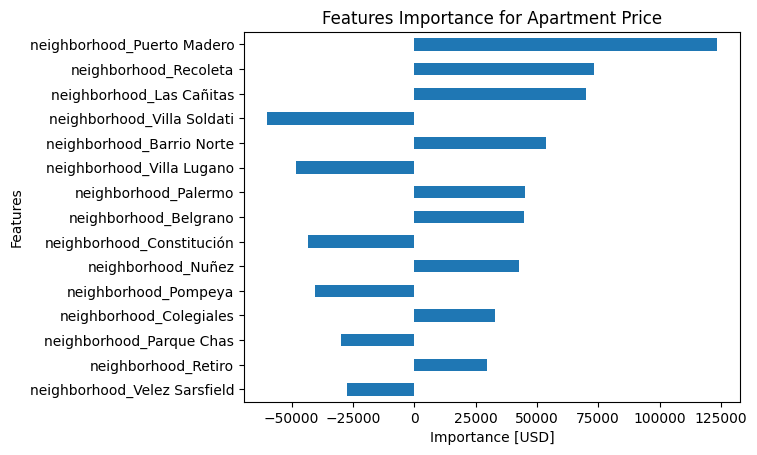

In [ ]:
# Bar chart that shows the top 15 coefficients for our model, based on their absolute value
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Features Importance for Apartment Price");